In [3]:
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
engine = create_engine("sqlite:///Resources/Hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measure = Base.classes.measurement
session = Session(engine)
#conn = engine.connect()

In [5]:
sql=f"select date,prcp from measurement where CAST((julianday('now') - julianday(date)) / 30 AS integer) < 24"
prcp_df = pd.read_sql(sql, engine, index_col="date")

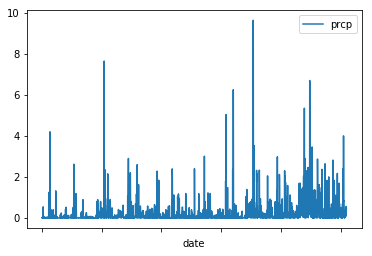

In [24]:
#prcp_df.plot(kind='bar', stacked=True, width=10,color="#9b59b6")
prcp_df.plot()


In [45]:
from sqlalchemy import distinct

#to calculate the total number of stations.
# from station table
print(session.query(func.count(Station.station).label('Total')).first())

#From measurement table
session.query(func.count(distinct(Measure.station))).first()


(9,)


(9)

In [34]:
#List the stations and observation counts in descending order
total_stations=session.query(Measure.station,func.count(Measure.station).label('Observation')).\
        group_by(Measure.station).order_by('Observation DESC')
for stat in total_stations:
    print(stat.station,stat.Observation)

USC00519281 2772
USC00513117 2696
USC00519397 2685
USC00519523 2572
USC00516128 2484
USC00514830 1937
USC00511918 1932
USC00517948 683
USC00518838 342


C:\Users\achole\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'Observation DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [35]:
#Which station has the highest number of observations?
session.query(Measure.station,func.count(Measure.station).label('Observation')).\
        group_by(Measure.station).order_by('Observation DESC').first()

C:\Users\achole\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'Observation DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


('USC00519281', 2772)

In [81]:
max_date_tuple=session.query(func.max(Measure.date).label('max_date')).\
        filter(Measure.station=='USC00519281').first()
    
start_date=max_date_tuple[0]-dt.timedelta(days=365)


datetime.date(2016, 8, 18)

In [ ]:
sql=f"select date,prcp from measurement where station='USC00519281' and date >{start_date}"
prcp_df = pd.read_sql(sql, engine, index_col="date")

In [57]:
def calc_temps(st_dt,end_dt):
    sel = [func.min(Measure.tobs).label('TMIN'), 
       func.max(Measure.tobs).label('TMAX'), 
       func.avg(Measure.tobs).label('TAVG')]
    start_date = dt.datetime.strptime(st_dt , '%Y-%m-%d')-dt.timedelta(days=1)
    end_date = dt.datetime.strptime(end_dt , '%Y-%m-%d')
    return session.query(*sel).filter(Measure.date >=start_date).filter(Measure.date<=end_date).first()


In [58]:
get_trip_temp=calc_temps("2010-01-01","2010-02-01")

<Container object of 1 artists>

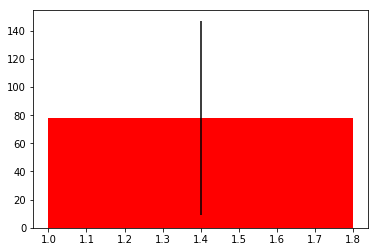

In [68]:
plt.bar((1), get_trip_temp[1], color="red", align="edge",yerr=get_trip_temp[2])